In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from scipy.stats import zscore
from sklearn.manifold import TSNE,Isomap
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans,AgglomerativeClustering,SpectralClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score,davies_bouldin_score,calinski_harabasz_score
from scipy.stats import kurtosis,skew
from sklearn.preprocessing import PowerTransformer
import ollama
from IPython.display import Markdown, display
import warnings

pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns',None)
pd.set_option('display.float_format', lambda x: '%.2f' % x)
warnings.filterwarnings("ignore")

In [2]:
df=pd.read_csv("../EDA_transform/data/data_clustering_combined.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 217072 entries, 0 to 217071
Data columns (total 35 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   vopenid                   217072 non-null  object 
 1   duration                  217072 non-null  int64  
 2   first_login_date          217072 non-null  object 
 3   last_login_date           217072 non-null  object 
 4   num_day_login             217072 non-null  int64  
 5   login_frequency           217072 non-null  float64
 6   avg_between_login         217072 non-null  float64
 7   streak_login              217072 non-null  int64  
 8   last_since_from_login     217072 non-null  int64  
 9   popular_time_login        217072 non-null  int64  
 10  gold_std_login            217072 non-null  float64
 11  diamond_std_login         217072 non-null  float64
 12  silkcoin_std_login        217072 non-null  float64
 13  gold_max                  217072 non-null  i

In [3]:
data_engag=df[['vopenid','num_day_login','streak_login','last_since_from_login','login_frequency']]
data_engag

,vopenid,num_day_login,streak_login,last_since_from_login,login_frequency
0,2206111754266455,2,2,48,1.00
1,2206111758351763,1,1,31,1.00
2,2206111808105074,2,2,10,3.00
3,2206111830413361,51,37,0,3.37
4,2206111904162575,1,1,37,1.00
...,...,...,...,...,...
217067,lkeu,2,1,8,1.00
217068,lknew,2,1,14,2.00
217069,tri3,1,1,9,2.00
217070,vtvinh,3,2,8,3.00


In [4]:
data_engag=data_engag[data_engag['num_day_login']>1]

In [5]:
for col in ['num_day_login', 'streak_login', 'last_since_from_login', 'login_frequency']:
    print(f'{col}: Skewness = {skew(data_engag[col]):.2f}')

num_day_login: Skewness = 0.44
streak_login: Skewness = 1.60
last_since_from_login: Skewness = 1.65
login_frequency: Skewness = 25.09


In [6]:
for col in ['num_day_login', 'streak_login', 'last_since_from_login', 'login_frequency']:
    print(f'{col}: Kurtosis = {kurtosis(data_engag[col], fisher=False):.2f}')

num_day_login: Kurtosis = 1.75
streak_login: Kurtosis = 4.80
last_since_from_login: Kurtosis = 4.69
login_frequency: Kurtosis = 1723.95


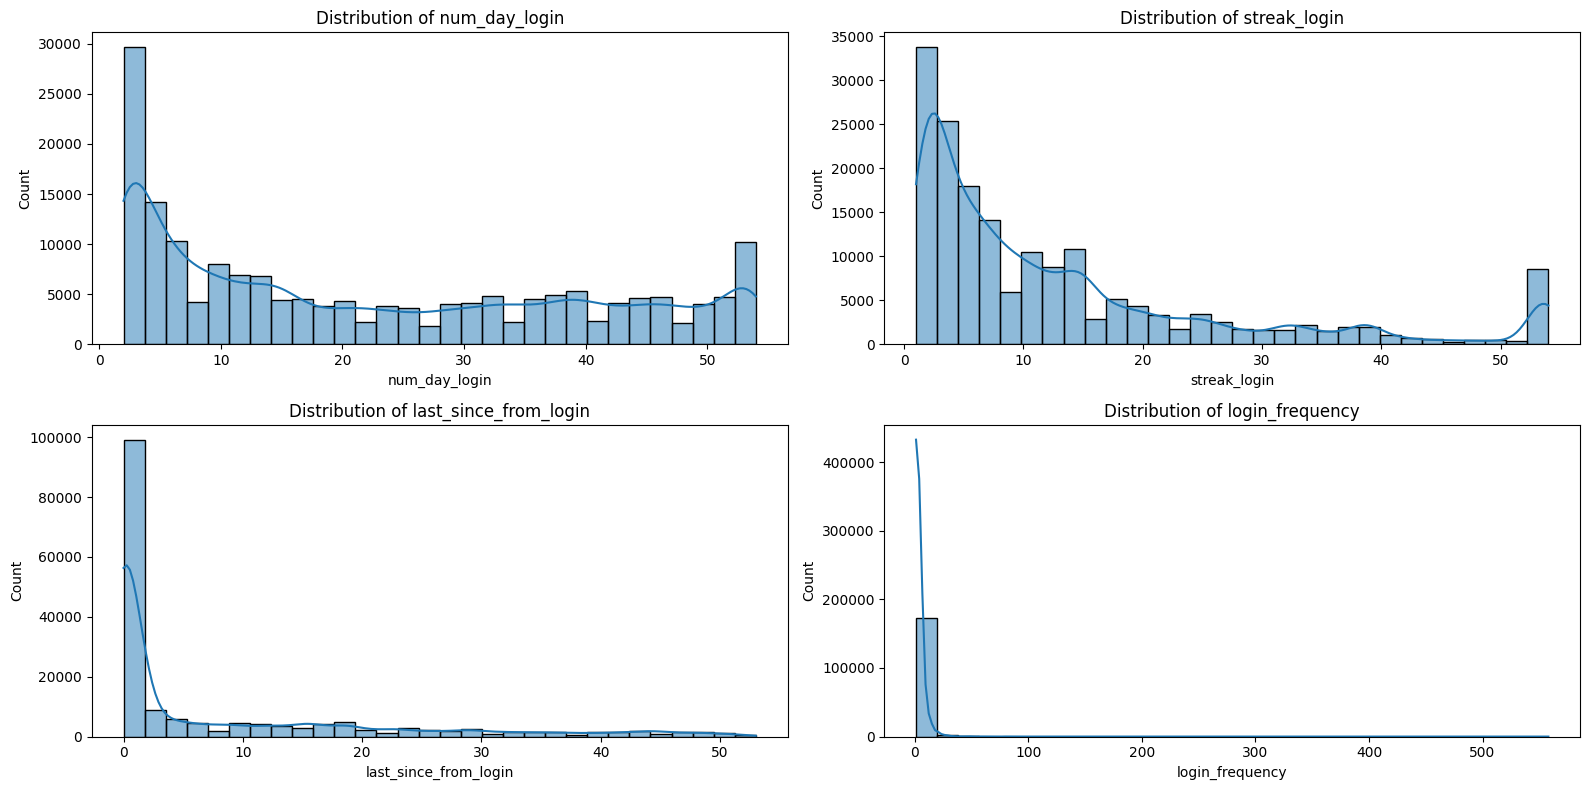

In [7]:
columns = [
    'num_day_login',
    'streak_login',
    'last_since_from_login',
    'login_frequency'
]

plt.figure(figsize=(16, 8))
for i, col in enumerate(columns, 1):
    plt.subplot(2, 2, i)
    sns.histplot(data_engag[col], kde=True, bins=30)
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

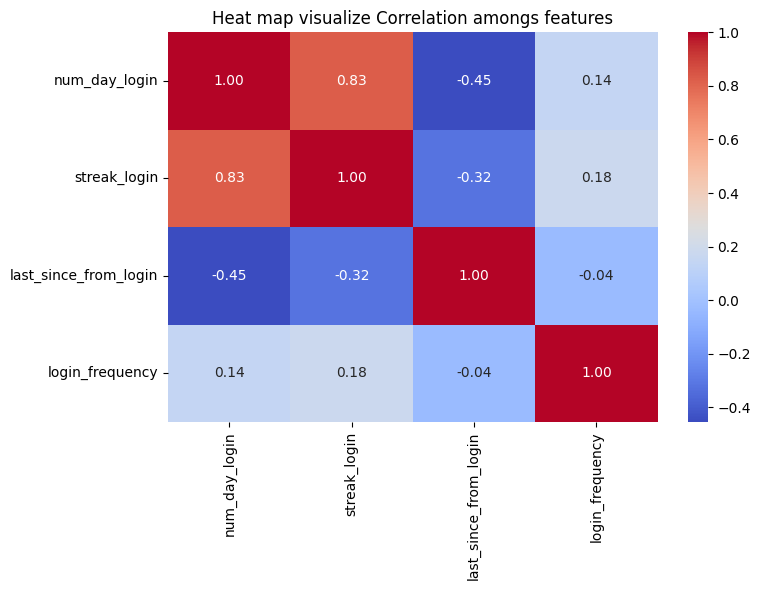

In [8]:
corr_cols = data_engag.drop(columns=['vopenid']).columns

plt.figure(figsize=(8,6))
sns.heatmap(data_engag[corr_cols].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Heat map visualize Correlation amongs features')
plt.tight_layout()
plt.show()

In [9]:
cols_purchase = [
    'num_day_login',
    'streak_login',
    'last_since_from_login',
    'login_frequency'
]

X = data_engag[cols_purchase]

from scipy.stats import zscore
z_scores = np.abs(zscore(X))
mask = (z_scores < 5).all(axis=1)  
X = X[mask]
data_engag = data_engag.loc[mask].reset_index(drop=True)

In [10]:
pt = PowerTransformer(method='yeo-johnson')
X = pt.fit_transform(X)
X

array([[-1.52253016, -1.24180853,  1.54927967, -1.72871106],
       [-1.52253016, -1.24180853,  0.98159218, -0.21526067],
       [ 1.35132564,  1.46667815, -0.98524696, -0.04789529],
       ...,
       [-1.52253016, -1.74814109,  1.12763247, -0.79590299],
       [-1.31714431, -1.24180853,  0.87739256, -0.21526067],
       [-0.55429603, -0.63498144, -0.2212807 , -0.32567804]])

In [11]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled.min(),X_scaled.max()

(np.float64(-1.7481410897009195), np.float64(2.664638026435043))

In [12]:
num_cluster = 5

In [13]:
kmeans = KMeans(n_clusters=num_cluster, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(X_scaled)
data_engag['kmeans_cluster'] = kmeans_labels 

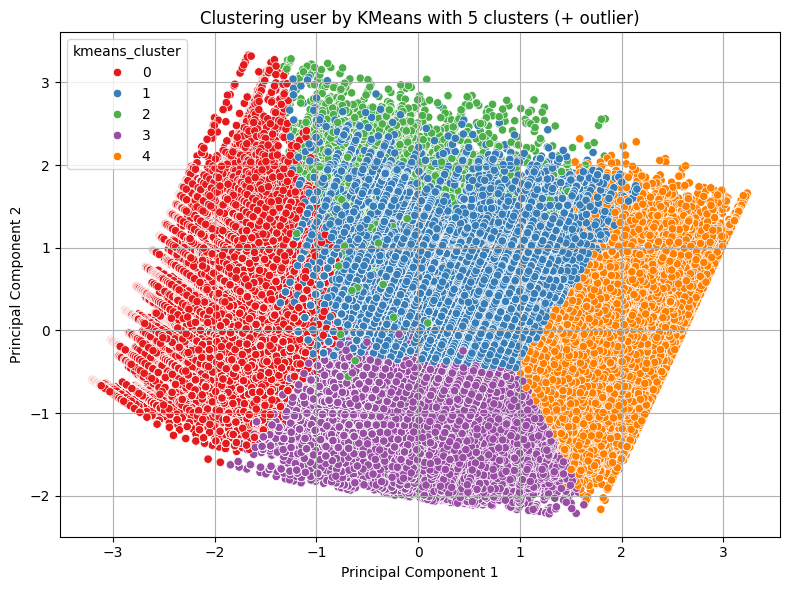

In [14]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X_scaled)

data_engag['pca_kmean_1'] = pca_result[:, 0]
data_engag['pca_kmean_2'] = pca_result[:, 1]

plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=data_engag,
    x='pca_kmean_1', y='pca_kmean_2',
    hue='kmeans_cluster', palette='Set1'
)
plt.title(f'Clustering user by KMeans with {num_cluster} clusters (+ outlier)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.tight_layout()
plt.show()

In [16]:
cluster_stats = data_engag.groupby('kmeans_cluster')[
    [
       'num_day_login', 
       'login_frequency',
       'streak_login', 
       'last_since_from_login', 
    ]   
].mean().round(2)

cluster_counts = data_engag['kmeans_cluster'].value_counts().sort_index().rename('num_users')
total_users = cluster_counts.sum()
cluster_summary = cluster_stats.join(cluster_counts)
cluster_summary['percent_users'] = (cluster_summary['num_users'] / total_users * 100).round(2)
cluster_summary = cluster_summary.sort_values(by='num_day_login', ascending=False)
cluster_summary

,num_day_login,login_frequency,streak_login,last_since_from_login,num_users,percent_users
kmeans_cluster,,,,,,
4,46.03,6.37,32.03,0.25,41552,23.81
2,22.02,5.30,13.39,19.00,26758,15.33
3,21.63,1.85,8.67,0.54,29955,17.16
1,17.55,7.85,8.12,0.29,28336,16.23
0,4.17,2.83,2.47,19.35,47937,27.47


In [17]:
ch_kmeans = calinski_harabasz_score(X_scaled, data_engag['kmeans_cluster'])
print(f"KMeans Calinski–Harabasz Index: {ch_kmeans:.4f}")

KMeans Calinski–Harabasz Index: 98859.4496


In [ ]:
db_kmeans = davies_bouldin_score(X_scaled, data_engag['kmeans_cluster'])
print(f"KMeans Davies–Bouldin Index: {db_kmeans:.4f}")

KMeans Davies–Bouldin Index: 1.0542


In [ ]:
# sh_kmeans = silhouette_score(X_scaled, data_engag['kmeans_cluster'])
# print(f"KMeans Silhouette score : {sh_kmeans:.4f}")

In [19]:
data_purchase=df[['vopenid','num_purchase','purchase_frequency','total_purchase','days_since_last_purchase']]
data_purchase

,vopenid,num_purchase,purchase_frequency,total_purchase,days_since_last_purchase
0,2206111754266455,0.00,0.00,0.00,54.00
1,2206111758351763,0.00,0.00,0.00,54.00
2,2206111808105074,0.00,0.00,0.00,54.00
3,2206111830413361,0.00,0.00,0.00,54.00
4,2206111904162575,0.00,0.00,0.00,54.00
...,...,...,...,...,...
217067,lkeu,0.00,0.00,0.00,54.00
217068,lknew,0.00,0.00,0.00,54.00
217069,tri3,0.00,0.00,0.00,54.00
217070,vtvinh,0.00,0.00,0.00,54.00


In [20]:
for col in ['num_purchase', 'total_purchase', 'days_since_last_purchase', 'purchase_frequency']:
    print(f'{col}: Skewness = {skew(data_purchase[col]):.2f}')

num_purchase: Skewness = 17.32
total_purchase: Skewness = 54.35
days_since_last_purchase: Skewness = -2.31
purchase_frequency: Skewness = 5.09


In [21]:
for col in ['num_purchase', 'total_purchase', 'days_since_last_purchase', 'purchase_frequency']:
    print(f'{col}: Kurtosis = {kurtosis(data_purchase[col], fisher=False):.2f}')

num_purchase: Kurtosis = 711.02
total_purchase: Kurtosis = 5655.94
days_since_last_purchase: Kurtosis = 6.78
purchase_frequency: Kurtosis = 48.00


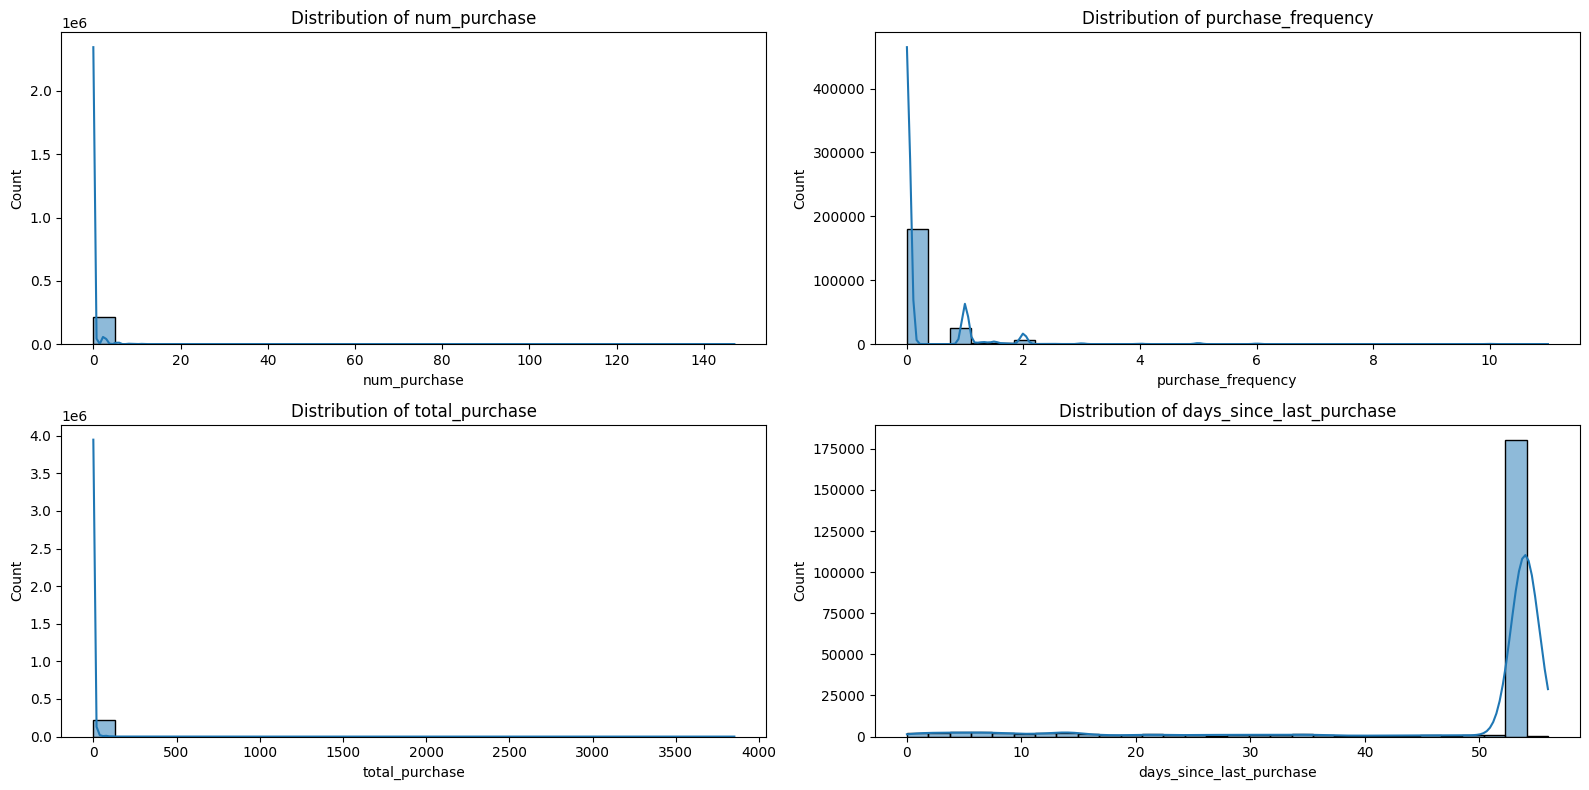

In [22]:
columns = [
    'num_purchase',
    'purchase_frequency',
    'total_purchase', 
    'days_since_last_purchase', 
]

plt.figure(figsize=(16, 8))
for i, col in enumerate(columns, 1):
    plt.subplot(2, 2, i)
    sns.histplot(data_purchase[col], kde=True, bins=30)
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

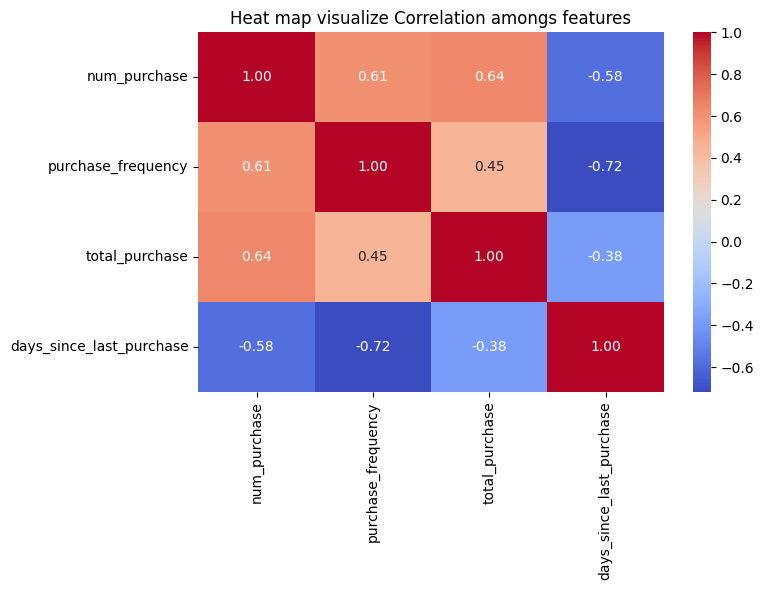

In [23]:
corr_cols = data_purchase.drop(columns=['vopenid']).columns

plt.figure(figsize=(8,6))
sns.heatmap(data_purchase[corr_cols].corr(), annot=True, cmap='coolwarm', fmt=".2f")

plt.title('Heat map visualize Correlation amongs features')
plt.tight_layout()
plt.show()

In [24]:
cols_purchase = [
    'num_purchase',
    'purchase_frequency',
    'total_purchase',
    'days_since_last_purchase'
]

X = data_purchase[cols_purchase]

pt = PowerTransformer(method='yeo-johnson')
X = pt.fit_transform(X)
X

array([[-0.45462496, -0.45474877, -0.45422029,  0.43373796],
       [-0.45462496, -0.45474877, -0.45422029,  0.43373796],
       [-0.45462496, -0.45474877, -0.45422029,  0.43373796],
       ...,
       [-0.45462496, -0.45474877, -0.45422029,  0.43373796],
       [-0.45462496, -0.45474877, -0.45422029,  0.43373796],
       [-0.45462496, -0.45474877, -0.45422029,  0.43373796]])

In [25]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled.min(),X_scaled.max()

(np.float64(-2.4855036997760727), np.float64(2.238592674283736))

In [ ]:
# from joblib import Parallel, delayed
# from sklearn.cluster import KMeans
# from sklearn.metrics import silhouette_score
# import matplotlib.pyplot as plt

# K_range = range(2, 9)
# def compute_metrics(k, X):
#     kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
#     labels = kmeans.fit_predict(X)
#     inertia = kmeans.inertia_
#     silhouette = silhouette_score(X, labels)
#     return inertia, silhouette

# results = Parallel(n_jobs=-1)(delayed(compute_metrics)(k, X_scaled) for k in K_range)

# inertia, silhouette = zip(*results)

# fig, ax1 = plt.subplots(figsize=(10, 5))
# color = 'tab:blue'
# ax1.set_xlabel('Number of Clusters (k)')
# ax1.set_ylabel('Inertia (Elbow)', color=color)
# ax1.plot(K_range, inertia, marker='o', color=color)
# ax1.tick_params(axis='y', labelcolor=color)

# ax2 = ax1.twinx()
# color = 'tab:red'
# ax2.set_ylabel('Silhouette Score', color=color)
# ax2.plot(K_range, silhouette, marker='s', linestyle='--', color=color)
# ax2.tick_params(axis='y', labelcolor=color)

# plt.title('Elbow & Silhouette Score for Optimal k')
# plt.tight_layout()
# plt.show()

In [26]:
num_cluster = 5
kmeans = KMeans(n_clusters=num_cluster, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(X_scaled)
data_purchase['kmeans_cluster'] = kmeans_labels

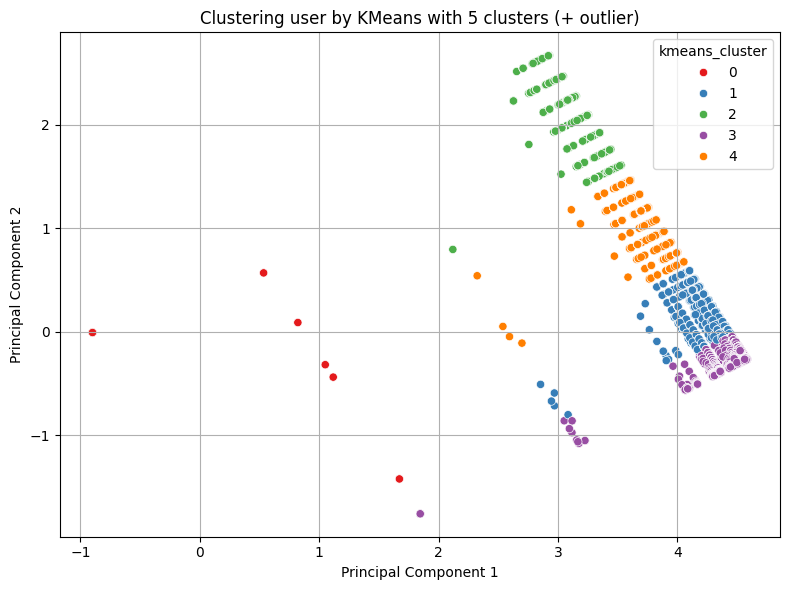

In [27]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X_scaled)

data_purchase['pca_kmean_1'] = pca_result[:, 0]
data_purchase['pca_kmean_2'] = pca_result[:, 1]

plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=data_purchase,
    x='pca_kmean_1', y='pca_kmean_2',
    hue='kmeans_cluster', palette='Set1'
)
plt.title(f'Clustering user by KMeans with {num_cluster} clusters (+ outlier)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.tight_layout()
plt.show()

In [28]:
cluster_stats = data_purchase.groupby('kmeans_cluster')[
    [
       'num_purchase',
       'purchase_frequency',
       'total_purchase', 
       'days_since_last_purchase', 
    ]   
].mean().round(2)

cluster_counts = data_purchase['kmeans_cluster'].value_counts().sort_index().rename('num_users')
total_users = cluster_counts.sum()
cluster_summary = cluster_stats.join(cluster_counts)
cluster_summary['percent_users'] = (cluster_summary['num_users'] / total_users * 100).round(2)
cluster_summary = cluster_summary.sort_values(by='total_purchase', ascending=False)
cluster_summary

,num_purchase,purchase_frequency,total_purchase,days_since_last_purchase,num_users,percent_users
kmeans_cluster,,,,,,
3,2.96,1.40,30.59,11.72,26308,12.12
1,1.87,1.45,22.32,34.68,5682,2.62
2,1.73,1.63,20.97,52.42,2366,1.09
4,1.59,1.29,16.21,45.53,2837,1.31
0,0.00,0.00,0.00,54.00,179879,82.87


In [29]:
ch_kmeans = calinski_harabasz_score(X_scaled, data_purchase['kmeans_cluster'])
print(f"KMeans Calinski–Harabasz Index: {ch_kmeans:.4f}")

KMeans Calinski–Harabasz Index: 31261843.6031


In [30]:
db_kmeans = davies_bouldin_score(X_scaled, data_purchase['kmeans_cluster'])
print(f"KMeans Davies–Bouldin Index: {db_kmeans:.4f}")

KMeans Davies–Bouldin Index: 0.4578


In [31]:
sh_kmeans = silhouette_score(X_scaled, data_purchase['kmeans_cluster'])
print(f"KMeans Silhouette score : {sh_kmeans:.4f}")

KMeans Silhouette score : 0.9448


In [ ]:
login_cols = [
    'vopenid',
    'gold_std_login', 'gold_slope_login',
    'diamond_std_login', 'diamond_slope_login',
    'silkcoin_std_login', 'silkcoin_slope_login',
    'powerpoint_last_login', 'vip_last_login', 'level_last_login'
]
equip_cols = ['vopenid', 'equi_beha']


df_merged = df_login[login_cols].merge(
    df_equip[equip_cols],
    on='vopenid',
    how='left'
)
df_merged['equi_beha'] = df_merged['equi_beha'].fillna('None')
# df_merged